## Setup

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

bin_count = 171
def create_test_train(data_set_path, test_size=0.10):
    """ Splits a given csv file into testing and training. Target column is all the bins."""
    # Make sure the columns are set
    data_set = pd.read_csv(data_set_path)

    # Shuffle the data
    data_set = data_set.sample(frac=1, random_state=0)
 
    # Select all except output bins
    data_set_X = data_set.drop([f'Output_Bin_{i}' for i in range(bin_count)], axis=1)
    # Select only the output bins
    data_set_Y = data_set[[f'Output_Bin_{i}' for i in range(bin_count)]]

    #Split into training and test data
    return train_test_split(data_set_X,
                            data_set_Y,
                            test_size=test_size, 
                            random_state=300)

filename= "/project/SDS-capstones-kropko21/uva-astronomy/dust_training_data_all_bins_v2.csv"
X_train, X_test, y_train, y_test = create_test_train(filename, test_size=0.10)

def evaluate_fit(y_samples, y_test):
    ent = []
    js_list = []

    # Turn all negative preds to 0
    y_samples = np.clip(y_samples,0, a_max=None)
    
    y_samples_obs = y_samples
    y_test_obs = y_test
    
    # Small constant to prevent inf for 0s
    c = 1e-100
    
    y_test_obs += c
    y_samples_obs += c

    fits = []
    for i in range(len(y_test_obs)):
        # Calcuate the two entropy measures
        e = entropy(y_test_obs.iloc[i], y_samples_obs[i])
        js = jensenshannon(y_test_obs.iloc[i], y_samples_obs[i])
        ent.append(e if e != np.inf else 1000)
        js_list.append(js)
        # Add the index and the two entropy measures to an array to be used for plotting later
        fits.append((i, ent, js))
    #print("Entropy")
    #display(pd.DataFrame(ent).describe())
    print("Jensen-Shannon")
    display(pd.DataFrame(js_list).describe().apply(lambda s: s.apply('{0:.4f}'.format)))
    return fits, js_list

def fit_for_model(filename, X_test, y_test):
    """ Loads and fits model from file. Evaluates against X,y test"""
    
    rf = load(filename)
    preds = rf.predict(X_test)
    
    # Renormalize samples
    preds_normalized = []
    for s in preds:
        preds_normalized.append(np.divide(s,np.sum(s)))
        
    preds_df = pd.DataFrame(preds_normalized, columns=[f'Output_Bin_{i}' for i in range(bin_count)])
    preds_df.to_csv("preds_small_model.csv")
    
    return evaluate_fit(preds_normalized, y_test), preds_normalized

In [2]:
from joblib import dump, load
import numpy as np
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

model_name = '/project/SDS-capstones-kropko21/uva-astronomy-models/rf-model-large.joblib'
m1_fit, model_1_preds = fit_for_model(model_name, X_test, y_test)
fits, model_1_js_list = m1_fit

/home/keh4nb/.local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Jensen-Shannon


,0
count,142330.0000
mean,0.0803
std,0.1214
min,0.0000
25%,0.0052
50%,0.0195
75%,0.1081
max,0.8159


## Calculate

In [15]:
err_fits_arr = []
# Calculate the absolute value of the different between predicted peak and actual peak
bin_error = np.abs(np.argmax(y_test.to_numpy(), axis=1) - np.argmax(model_1_preds, axis=1))
#bin_error = np.sqrt(((np.argmax(y_test.to_numpy(), axis=1) - np.argmax(model_1_preds, axis=1)) ** 2))


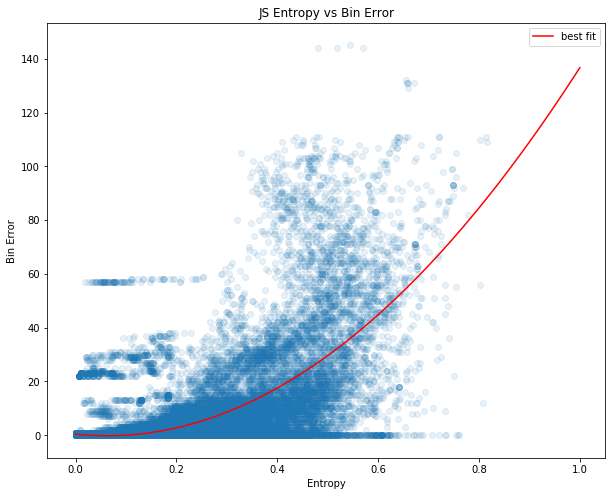

In [18]:
import matplotlib.pyplot as plt
#from statsmodels.nonparametric.smoothers_lowess import lowess

plt.figure(figsize=(10, 8))
#Lowess cannot fit with large number of ties https://github.com/statsmodels/statsmodels/issues/2449
#ys = lowess(model_1_js_list, bin_error)
#plt.plot(bin_error,ys,'red',linewidth=1)
#plt.plot(evalDF['v'], evalDF['g'], color='red', linewidth= 3, label="Fit")

model_2 = np.poly1d(np.polyfit( model_1_js_list, bin_error, 2))

modal_eval = np.linspace(0, 1, 100)

plt.plot(modal_eval, model_2(modal_eval), color="red", label="best fit")
plt.scatter(model_1_js_list,bin_error,  alpha=0.1)
plt.title("JS Entropy vs Bin Error")
plt.xlabel('Entropy')
plt.ylabel('Bin Error')
plt.legend()
plt.show()